In [115]:
import torch
import math
import numpy as np
import xalglib
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Problem

## sklearn: LogisticRegression

In [141]:
X, y = load_breast_cancer(True)
X = (X - X.mean(axis=0)) / X.std(axis=0) + np.random.randn(*X.shape)
X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

In [142]:
log_reg = LogisticRegression(penalty='none', fit_intercept=False, solver='newton-cg')
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [143]:
x_opt = log_reg.coef_[0]

In [144]:
x_opt

array([-1.02113426, -1.01759864, -1.22190094, -0.09142531, -0.7783932 ,
        0.02769471, -0.61864643,  0.06388162, -0.30859186, -0.16114696,
       -0.56493357, -0.11705911, -0.93835045, -0.30282753,  0.02375118,
        0.34512935, -0.01654348, -0.44202193,  0.52003334,  0.72389108,
       -0.47485271, -0.63893112, -0.97078704, -0.20641206, -0.19279566,
       -0.68856758, -0.66203852, -0.77524301, -0.58530262, -0.04631652,
        1.05121295])

In [145]:
log_reg.score(X, y)

0.9472759226713533

In [146]:
log_loss(y, log_reg.predict_proba(X))

0.12202827234378548

## PyTorch: optimization problem

In [147]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

x_opt = torch.tensor(x_opt, dtype=torch.float32)
N = x_opt.shape[0]

x_0 = torch.randn(N)

In [148]:
def f(x):
    return torch.nn.functional.binary_cross_entropy_with_logits(X @ x, y)

In [149]:
f(x_opt).item()

0.12202827632427216

In [150]:
f(x_0).item()

1.046837568283081

# Constants

In [4]:
I = torch.eye(N)

# Helper functions

In [5]:
def d_p(x, p):
    '''
    Prox-function
    '''
    return 1 / p * x**p


def gradient(f, x, create_graph=False, retain_graph=None):
    '''
    Gradient of scalar function 'f' w.r.t. 1-d vector 'x'
    '''
    return torch.autograd.grad(
        outputs=[f],
        inputs=[x],
        create_graph=create_graph, 
        retain_graph=retain_graph)[0]


def hessian(f, x, create_graph=False):
    '''
    Hessian of scalar function 'f' w.r.t. 1-d vector 'x'
    '''
    n = x.shape[0]
    h = torch.empty(n, n)
    g = gradient(f, x, True)
    for i in range(n):
        h[i] = gradient(g[i], x, create_graph, True)
    return h


def hessian_vector_product(f, x, v, retain_graph=False):
    '''
    Hessian-vector product: D^2(f) @ v
    '''
    grad_f = gradient(f, x, True)
    return gradient(grad_f @ v, x, retain_graph=retain_graph)

In [6]:
x = torch.tensor([1.5, 2.5], requires_grad=True)
e = torch.tensor([1., 1.])
f = x.pow(2).prod()
print('F =', f, '\n')

g = gradient(f, x, retain_graph=True)
print('g =', g, '\n')

h = hessian(f, x)
print('h =', h, '\n')

he = hessian_vector_product(f, x, e, retain_graph=True)
print('h @ e =', he, '\n')

F = tensor(14.0625, grad_fn=<ProdBackward0>) 

g = tensor([18.7500, 11.2500]) 

h = tensor([[12.5000, 15.0000],
        [15.0000,  4.5000]]) 

h @ e = tensor([27.5000, 19.5000]) 



# Auxilary problem

In [31]:
def tridiag(d, e):
    '''
    Construct symmetric tridiagonal matrix from its main diagonal d and 
    above/below main diagonals equal to e
    '''
    return torch.diag(d) + torch.diag(e, -1) + torch.diag(e, 1)


def utu_decomposition(A):  # TODO
    '''
    Decomposition of symmetric matrix A to U @ T @ U.T, where
    U - symmetric ortogonal matrix, T - symmetric tridiagonla matrix
    '''
    a = A.tolist()
    a, tau, d, e = xalglib.smatrixtd(a, N, True)
    u = xalglib.smatrixtdunpackq(a, N, True, tau)
    U = torch.tensor(u)
    T = tridiag(torch.tensor(d), torch.tensor(e))
    return T, U


def auxilary_subproblem_objective(tau, T, c_tilda, gamma):
    value = tau**2 + .5 * c_tilda.T @ torch.inverse(2 * math.sqrt(gamma) * tau * I + T) @ c_tilda
    return value


def solve_auxilary_subproblem(T, c_tilda, gamma, learning_rate):
    tau = torch.tensor(1, dtype=torch.float32, requires_grad=True)
    for i in range(1000):  # TODO
        value = auxilary_subproblem_objective(tau, T, c_tilda, gamma)
        value.backward()
        with torch.no_grad():
            tau -= learning_rate * tau.grad
        tau.grad.detach_()
        tau.grad.zero_()
    return tau


def solve_auxilary_problem(A, c, gamma):
    T, U = utu_decomposition(A)
    c_tilda = U.T @ c

    tau = solve_auxilary_subproblem(T, c_tilda, gamma, 0.1)
    assert tau > 0
    h = -U @ torch.inverse(2 * math.sqrt(gamma) * tau * I + T) @ c_tilda
    
    return h

def auxilary_subproblem_dummy_objective(h, A, c, gamma):
    value = c @ h + .5 * h.T @ A @ h +  gamma * torch.norm(h)**4 / 4
    return value

def solve_auxilary_problem_dummy(A, c, gamma, learning_rate=0.001):
    h = torch.tensor([1, 1, 1, 1], dtype=torch.float32, requires_grad=True)
    for i in range(1000): 
        value = auxilary_subproblem_dummy_objective(h, A, c, gamma)
        value.backward()
        with torch.no_grad():
            h -= learning_rate * h.grad
        h.grad.detach_()
        h.grad.zero_()
    return h


In [32]:
A = torch.tensor([
    [-1, -2, 1, 2],
    [-2, 3, 0, -2],
    [1, 0, 2, 1],
    [2, -2, 1, 4]
], dtype=torch.float32)
c = torch.ones(4)
gamma = 1

T, U = utu_decomposition(A)
print('A =', A, '\n')
print('T =', T, '\n')
print('U =', U, '\n')
print('U @ T @ U.T =', U @ T @ U.T, '\n')

A = tensor([[-1., -2.,  1.,  2.],
        [-2.,  3.,  0., -2.],
        [ 1.,  0.,  2.,  1.],
        [ 2., -2.,  1.,  4.]]) 

T = tensor([[ 1.9867,  0.9067,  0.0000,  0.0000],
        [ 0.9067, -1.3200, -1.6667,  0.0000],
        [ 0.0000, -1.6667,  3.3333, -3.0000],
        [ 0.0000,  0.0000, -3.0000,  4.0000]]) 

U = tensor([[ 0.1333, -0.7333, -0.6667,  0.0000],
        [-0.3333, -0.6667,  0.6667,  0.0000],
        [-0.9333,  0.1333, -0.3333,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]]) 

U @ T @ U.T = tensor([[-1.0000e+00, -2.0000e+00,  1.0000e+00,  2.0000e+00],
        [-2.0000e+00,  3.0000e+00,  8.1956e-08, -2.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  2.0000e+00,  1.0000e+00],
        [ 2.0000e+00, -2.0000e+00,  1.0000e+00,  4.0000e+00]]) 



A = tensor([[ 0.6765, -0.0982,  0.1304, -0.1185],
        [-0.0982,  2.0807,  1.2106, -0.5858],
        [ 0.1304,  1.2106,  2.0195, -0.8538],
        [-0.1185, -0.5858, -0.8538,  1.1101]]) 

T = tensor([[0.5778, 0.0224, 0.0000, 0.0000],
        [0.0224, 1.0507, 0.5001, 0.0000],
        [0.0000, 0.5001, 3.1482, 1.0422],
        [0.0000, 0.0000, 1.0422, 1.1101]]) 

U = tensor([[ 0.8813,  0.4587, -0.1137,  0.0000],
        [ 0.3236, -0.7611, -0.5621,  0.0000],
        [-0.3443,  0.4586, -0.8192,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]]) 

U @ T @ U.T = tensor([[ 0.6765, -0.0982,  0.1304, -0.1185],
        [-0.0982,  2.0807,  1.2106, -0.5858],
        [ 0.1304,  1.2106,  2.0195, -0.8538],
        [-0.1185, -0.5858, -0.8538,  1.1101]]) 

tau = tensor(0.2922, requires_grad=True) 



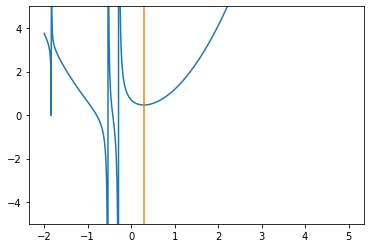

In [33]:
c = torch.randn(N)
x = torch.randn(N, requires_grad=True)
f = -sum(torch.log(torch.sigmoid(x @ torch.randn(4))) for _ in range(10))
A = hessian(f, x)
gamma = 1

T, U = utu_decomposition(A)
print('A =', A, '\n')
print('T =', T, '\n')
print('U =', U, '\n')
print('U @ T @ U.T =', U @ T @ U.T, '\n')

tau = solve_auxilary_subproblem(T, c, gamma, 0.1)
print('tau =', tau, '\n')

xx = np.linspace(-2, 5, 1000)
y = [auxilary_subproblem_objective(x, T, c, gamma) for x in xx]
plt.plot(xx, y)
plt.ylim(-5, 5)
plt.plot([tau, tau], [-5, 5])

A = tensor([[1.5908, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4513, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1299, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5751]]) 

c = tensor([ 0.0000, 17.9558,  0.0000,  0.0000]) 

gamma = tensor([46.2580]) 

h = tensor([ 0.0000, -0.7250,  0.0000,  0.0000], grad_fn=<MvBackward>)


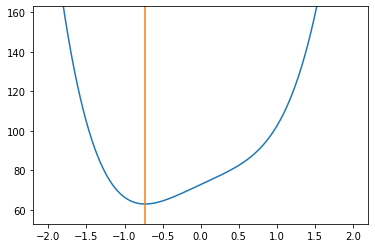

In [36]:
A = torch.diag(torch.abs(torch.randn(N)))
k = 1
e_k = torch.zeros(N)
e_k[k] = 1
c = (10 + 10 * torch.abs(torch.randn(1))) * e_k
gamma = 100 * torch.abs(torch.randn(1))

print('A =', A, '\n')
print('c =', c, '\n')
print('gamma =', gamma, '\n')

h = solve_auxilary_problem(A, c, gamma)
print('h =', h)

def f(h):
    return c @ h + .5 * c.T @ A @ c + gamma * torch.norm(h)**4 / 4

xx = np.linspace(-2, 2, 1000)
yy = [f(x * e_k) for x in xx]
plt.plot(xx, yy)
y1, y2 = min(yy) - 10, min(yy) + 100
plt.ylim(y1, y2)
plt.plot([h[k], h[k]], [y1, y2])

A = tensor([[0.9093, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0283, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.3992, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.4463]]) 

c = tensor([ 0.0000, 18.6024,  0.0000,  0.0000]) 

gamma = tensor([100.3688]) 

h = tensor([ 1.2977e-15, -5.6999e-01,  7.8147e-16,  2.0953e-15],
       requires_grad=True)


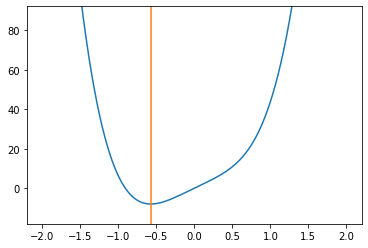

In [28]:
A = torch.diag(torch.abs(torch.randn(N)))
k = 1
e_k = torch.zeros(N)
e_k[k] = 1
c = (10 + 10 * torch.abs(torch.randn(1))) * e_k
gamma = 100 * torch.abs(torch.randn(1))

print('A =', A, '\n')
print('c =', c, '\n')
print('gamma =', gamma, '\n')

h = solve_auxilary_problem_dummy(A, c, gamma)
print('h =', h)

def f(h):
    return c @ h + .5 * h.T @ A @ h + gamma * torch.norm(h)**4 / 4

xx = np.linspace(-2, 2, 1000)
yy = [f(x * e_k) for x in xx]
plt.plot(xx, yy)
y1, y2 = min(yy) - 10, min(yy) + 100
plt.ylim(y1, y2)
plt.plot([h[k], h[k]], [y1, y2])

# Bregman-distance gradient method

In [31]:
def BDGM(f, x_tilda_k, delta, L3):
    
    grad_f_x_tilda_k = torch.autograd.grad([f(x_tilda_k)], [x_tilda_k], create_graph=True)[0]
    
    z_0 = x_tilda_k
    tau = 3 * delta / (8 * (2 + math.sqrt(2)) * torch.norm(grad_f))
    
    def D2v(z):
        return hessian_vector_product(f, x_tilda_k, z - x_tilda_k)
    
    def rho_k(z):
        '''
        Scaling function
        '''
        return .5 * D2v(f, x_tilda_k, z - x_tilda_k) @ (z - x_tilda_k) \
               + L3 * d_p(z - x_tilda_k, 4)
    
    def beta_rho_k(z_i, z):
        '''
        Bregman distance
        '''
        grad_rho_k = torch.autograd.grad([rho_k(z)])
        return rho_k(z) - rho_k(z_i) - grad_rho_k @ (z - z_i)
    
    def g_x_tilda_k_tau(z):
        grad_g_p = torch.autograd.grad([f(x_tilda_k + tau * (z - x_tilda_k))], [x], create_graph=True)[0]
        grad_g_n = torch.autograd.grad([f(x_tilda_k - tau * (z - x_tilda_k))], [x], create_graph=True)[0]
        return 1 / tau**2 * (grad_g_p + grad_g_n - 2 * grad_f_x_tilda_k)
    
    def g_phi_k_tau(z):
        return grad_f_x_tilda_k + D2v(z) + g_x_tilda_k_tau(z) + L3 * ((z - x_tilda_k)**2).sum() * (z - x_tilda_k)
    
    def auxilary_subproblem_dummy_objective(z, g_phi_k_tau_z_i, z_i): 
        value = g_phi_k_tau_z_i @ (z - z_i) + 2 * (1 + 2**(-.5))*beta_rho_k(z_i, z)
        return value
    
    def solve_auxilary_problem_dummy(g_phi_k_tau_z_i, z_i, learning_rate=0.001):
        z = torch.ones(len(z_i), dtype=torch.float32, requires_grad=True)
        for i in range(1000): 
            value = auxilary_subproblem_dummy_objective(z, g_phi_k_tau_z_i, z_i)
            value.backward()
            with torch.no_grad():
                z -= learning_rate * h.grad
            z.grad.detach_()
            z.grad.zero_()
        return z
    
    i = 0
    z_i = z_0
    while True:
        g_phi_k_tau_z_i = g_phi_k_tau(z_i)
        grad_f_z_i = torch.autograd.grad([f(z_i)], [z_i], create_graph=True)[0]
        if torch.norm(g_phi_k_tau_z_i) < 1 / 6 * torch.norm(grad_f_z_i) - delta:
            break
        else:
            z_i_next = solve_auxilary_problem_dummy(g_phi_k_tau_z_i, z_i)
        i += 1

In [ ]:
def check_optimality(f, x, step=1e-3, eps=1e-5):
    n = x.shape[0]
    fx = f(x)
    for i in range(n):
        y = x
        y[i] += step
        fy = f(y)
        if fy < fx - eps:
            return False
    return True

# Hyperfast Second-Order Method

In [399]:
import numpy as np

def square_norm(x):
    return torch.sum(torch.tensor(x)**2)

def hyperfast_second_order_method(f, y_0, K, L3, delta):
    '''
    Algorithm 2: Hyperfast Second-Order Method
    '''
    A_0 = 0
    x_0 = y_0 
    x_tilda_k = x_0
    A_k = A_0
    x_k = x_0
    y_k = y_0
    for k in range(K):
        y_k_plus_1 = BDGM(f, x_tilda_k, delta, L3)
        y_k_plus_1.requires_grad_()
        lambda_min = 2 / (3 * L3 * square_norm(y_k_plus_1 - x_tilda_k))
        lambda_max = 1 / (L3 * square_norm(y_k_plus_1 - x_tilda_k))
        lambda_k_plus_1 = np.random.uniform(lambda_min, lambda_max)
        a_k_plus_1 = 1 / 2 * (lambda_k_plus_1 +
                              (lambda_k_plus_1 ** 2 +
                               4 * lambda_k_plus_1 * A_k) ** 0.5)
        A_k_plus_1 = a_k_plus_1 + A_k
        x_tilda_k = A_k * y_k / A_k_plus_1 + a_k_plus_1 * x_k / A_k_plus_1
        x_k = x_k - a_k_plus_1 * torch.autograd.grad([f(y_k_plus_1)],
                                                     [y_k_plus_1],
                                                     create_graph=True)[0]
        A_k = A_k_plus_1
        y_k = y_k_plus_1      
    return y_k